In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
import pyroll.core as pr
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [7]:
from rolling_sequence import rolling_train_e112, rolling_train_e107
from utilities import *

In [8]:
rolling_train_e112 = rolling_train_e112(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_e107 = rolling_train_e107(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [9]:
def calculate_wear_areas():
    sequences = [
        {"label": "e11_2", "sequence": rolling_train_e112},
        {"label": "e10_7", "sequence": rolling_train_e107}
    ]

    wear_areas = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:
                        wear_area = calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour)
                        wear_areas.append({
                            "groove": groove_label,
                            "measurement_id": measurement_id,
                            "label": label,
                            "tonnage": tonnage,
                            "wear_area": wear_area
                        })

    return wear_areas

In [10]:
wear_areas = calculate_wear_areas()

In [11]:
grouped = defaultdict(lambda: {'tonnage': [], 'wear_area': []})

for entry in wear_areas:
    key = (entry['groove'], entry['label'])
    grouped[key]['tonnage'].append(entry['tonnage'])
    grouped[key]['wear_area'].append(entry['wear_area'])

grouped = dict(grouped)

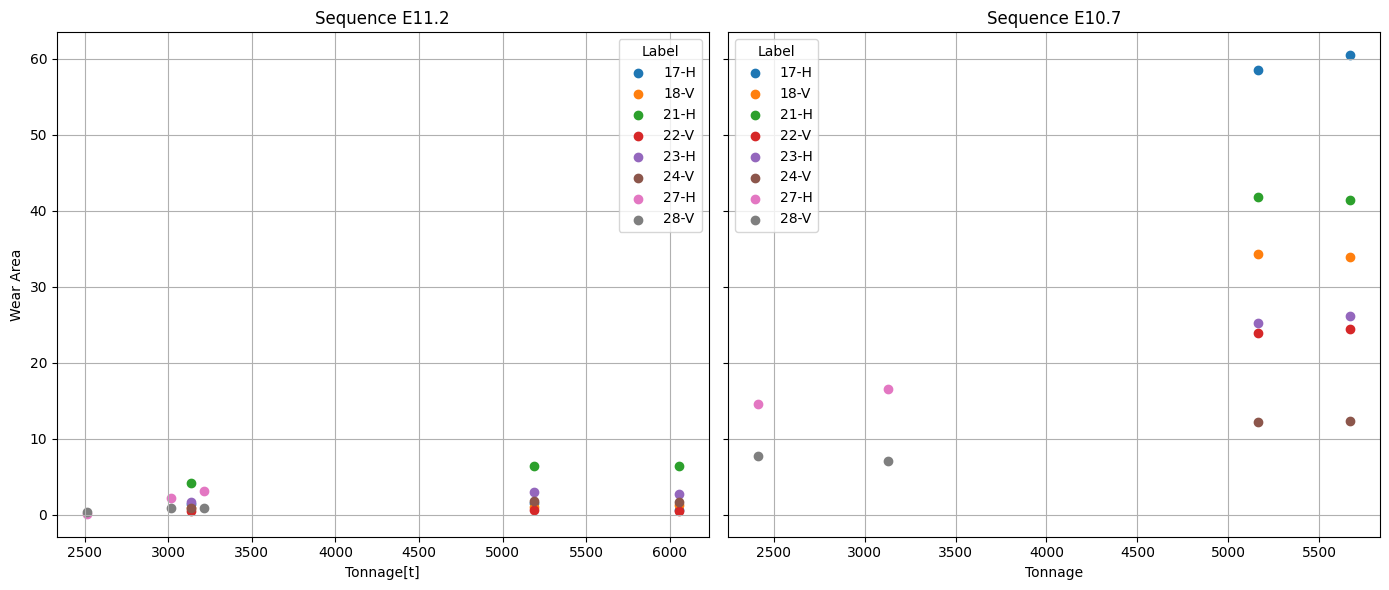

In [19]:
label_colors = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, label in enumerate(sorted(set(d['label'] for d in wear_areas))):
    label_colors[label] = color_cycle[i % len(color_cycle)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'e11_2':
        ax1.scatter(wear_dicts['tonnage'], wear_dicts['wear_area'] * 1e6, color=label_colors[wear_dicts['label']], label=wear_dicts['label'])

ax1.set_title('Sequence E11.2')
ax1.set_xlabel('Tonnage[t]')
ax1.set_ylabel('Wear Area')
ax1.grid()

handles1, labels1 = ax1.get_legend_handles_labels()
by_label1 = dict(zip(labels1, handles1))
ax1.legend(by_label1.values(), by_label1.keys(), title="Label")


for wear_dicts in wear_areas:
    if wear_dicts['groove'] == 'e10_7':
        ax2.scatter(wear_dicts['tonnage'], wear_dicts['wear_area'] * 1e6, color=label_colors[wear_dicts['label']], label=wear_dicts['label'])

ax2.set_title('Sequence E10.7')
ax2.set_xlabel('Tonnage')
ax2.grid()

handles2, labels2 = ax2.get_legend_handles_labels()
by_label2 = dict(zip(labels2, handles2))
ax2.legend(by_label2.values(), by_label2.keys(), title="Label")

plt.tight_layout()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---- 1. Daten aggregieren ----
# DataFrame mit columns: groove, label, tonnage, wear_area
df = pd.DataFrame(data)

# Feature-Extraction: je groove + label
grouped = df.groupby(['groove', 'label'])

feature_list = []
index = []

for (groove, label), group in grouped:
    group = group.sort_values('tonnage')
    tonnage = group['tonnage'].values
    wear = group['wear_area'].values

    # Feature: mittlerer Verschleiß
    mean_area = np.mean(wear)

    # Feature: lineare Steigung (wear vs tonnage)
    if len(tonnage) > 1:
        slope, _ = np.polyfit(tonnage, wear, 1)
    else:
        slope = 0  # oder np.nan

    var_area = np.var(wear)

    feature_list.append([mean_area, slope, var_area])
    index.append((groove, label))

X = np.array(feature_list)
X_scaled = StandardScaler().fit_transform(X)

# ---- 2. DBSCAN Clustering ----
db = DBSCAN(eps=1.0, min_samples=2)
labels = db.fit_predict(X_scaled)

# ---- 3. Ergebnisse visualisieren ----
label_df = pd.DataFrame(index=index, data={
    'cluster': labels,
    'mean_area': X[:, 0],
    'slope': X[:, 1],
    'var_area': X[:, 2]
}).reset_index()
label_df.columns = ['groove', 'label', 'cluster', 'mean_area', 'slope', 'var_area']

# Farben für Cluster
unique_clusters = sorted(label_df['cluster'].unique())
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 6))
for i, row in label_df.iterrows():
    cluster = row['cluster']
    color = 'gray' if cluster == -1 else colors(cluster)
    plt.scatter(row['slope'], row['mean_area'], color=color, s=80)
    plt.text(row['slope'], row['mean_area'], f"{row['label']}", fontsize=9, alpha=0.7)

plt.xlabel("Slope (wear vs. tonnage)")
plt.ylabel("Mean Wear Area")
plt.title("DBSCAN Clustering on Wear Behavior")
plt.grid(True)
plt.show()
